### Checking correlation between wind speed and WP gen in model ###

To try and see whether dates have become offset

-----------------------

In [1]:
# Local imports
import os
import sys
import glob
import time
import json
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [34]:
# Set up the hard-coded variables and paths
test_init_year = 1961
test_mem = 1
test_lead = 3336
test_winter_year = 1
members_list = np.array([10, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Set up the directories in which the data are stored
arrs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"
# dfs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/"
local_df_dir = "/home/users/benhutch/unseen_multi_year/dfs"
metadata_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/"

# Set up the fnames for the variables
test_fname_1984 = "HadGEM3-GC31-MM_psl_NA_1984_DJF_day.npy"
test_fname_1984_tas = "HadGEM3-GC31-MM_tas_Europe_1984_DJF_day.npy"
test_fname_1984_wind = "HadGEM3-GC31-MM_sfcWind_Europe_1984_DJF_day.npy"
df_fname = "full_field_model_tas_wind_UK_1961-2024_DJF_detrended_01-07-2025_dnw.csv"
obs_df_fname = "full_field_obs_tas_wind_UK_1961-2024_DJF_detrended_01-07-2025_dnw.csv"
lats_NA_fname = "HadGEM3-GC31-MM_psl_NA_1960_DJF_day_lats.npy"
lons_NA_fname = "HadGEM3-GC31-MM_psl_NA_1960_DJF_day_lons.npy"

In [30]:
output_df_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/model/WP_gen"

test_fname = "HadGEM3-GC31-MM_WP_gen_United_Kingdom_1961_drift_bc_dt.csv"

In [31]:
# Load in the data for wp generation 1961
df_wp_1961 = pd.read_csv(os.path.join(output_df_path, test_fname))

In [32]:
df_wp_1961.head()

,member,lead,wyear,capacity_factor,init_year
0,1,1,1,0.853584,1961
1,1,1,2,0.119135,1961
2,1,1,3,0.373296,1961
3,1,1,4,0.455344,1961
4,1,1,5,0.751949,1961


In [33]:
# --------------------
# Load in the csv data
# --------------------

df = pd.read_csv(os.path.join(local_df_dir, df_fname))

In [35]:
# limit to the test init year, test member, and winter year
df_first = df[
    (df["init_year"] == test_init_year)
    & (df["member"] == test_mem)
    & (df["winter_year"] == test_winter_year)
]

In [37]:
# liimit the df_wp_1961 to the same init year, member, and winter year
df_wp_1961 = df_wp_1961[
    (df_wp_1961["init_year"] == test_init_year)
    & (df_wp_1961["member"] == test_mem)
    & (df_wp_1961["wyear"] == test_winter_year)
]

In [39]:
df_first.shape, df_wp_1961.shape

((90, 25), (91, 5))

In [44]:
df_first.head(), df_wp_1961.head()

(      init_year  member  lead    data_tas  data_sfcWind  delta_p_hpa  \
 9000       1961       1    31  277.773039      7.363537    -13.93860   
 9001       1961       1    32  279.355490     11.141534    -17.93845   
 9002       1961       1    33  277.378594     10.545053    -15.62980   
 9003       1961       1    34  277.421735      7.703088    -21.23864   
 9004       1961       1    35  281.037178     12.859935    -34.91730   
 
        data_uas  data_vas  winter_year  effective_dec_year  ...  \
 9000   1.911971  1.043354            1                1961  ...   
 9001   7.412937  3.115626            1                1961  ...   
 9002   7.679653 -7.143181            1                1961  ...   
 9003   5.730084  1.424377            1                1961  ...   
 9004  11.857266  3.264202            1                1961  ...   
 
       normalized_dec_year  trend_value  data_tas_c_drift_bc_dt  data_tas_c_dt  \
 9000                    0      2.92305                6.431042     

Text(0.5, 1.0, 'CF and Wind Speed for 1961 Member 1 Winter Year 1\nPearson Correlation: -0.20')

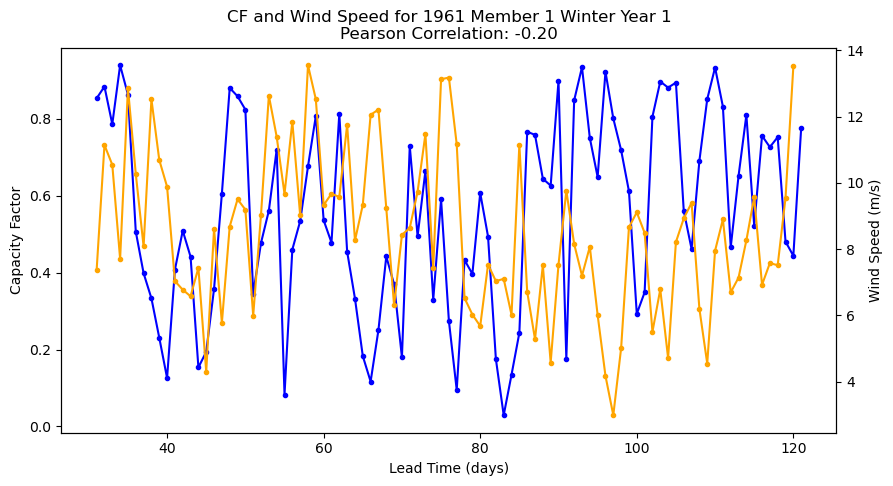

In [48]:
from scipy.stats import pearsonr

# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the df_wp_1961 data
ax.plot(
    df_wp_1961["lead"] + 30,
    df_wp_1961["capacity_factor"],
    label="CF",
    color="blue",
    marker="o",
    markersize=3,
    linestyle="-",
)

# duplicate t y-axis for the wind speed
ax2 = ax.twinx()
ax2.plot(
    df_first["lead"],  # Offset the lead time for clarity
    df_first["data_sfcWind"],
    label="Wind Speed",
    color="orange",
    marker="o",
    markersize=3,
    linestyle="-",
)

corr, _ = pearsonr(
    df_wp_1961["capacity_factor"][:-1],
    df_first["data_sfcWind"],
)

# Set the labels and title
ax.set_xlabel("Lead Time (days)")
ax.set_ylabel("Capacity Factor")
ax2.set_ylabel("Wind Speed (m/s)")
ax.set_title(
    f"CF and Wind Speed for {test_init_year} Member {test_mem} Winter Year {test_winter_year}\n"
    f"Pearson Correlation: {corr:.2f}"
)  

In [23]:
# Load in the obs data
obs_df = pd.read_csv(os.path.join(local_df_dir, obs_df_fname))

In [28]:
# set time as a datetime object
obs_df["time"] = pd.to_datetime(obs_df["time"], format="%Y-%m-%d")

# Set this as the index
obs_df.set_index("time", inplace=True)

In [6]:
# ------------------------
# Now we want to find the index of the leads for the test winter year
# ------------------------

# Define the winter years
winter_year = np.arange(1, 11 + 1)

# Set up a dictionary for the indices
indices_dict = {}

# Loop through the winter years and find the indices
for i, wyear in enumerate(winter_year):
    # set up the leads_djf to extract
    leads_djf = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    leads_djs_indices = leads_djf - 1

    # Prin the wyear and the min amd max index
    print(
        f"Winter year: {wyear}, Min index: {leads_djs_indices.min()}, Max index: {leads_djs_indices.max()}"
    )

    # Store the indices in the dictionary
    indices_dict[wyear] = leads_djs_indices

Winter year: 1, Min index: 30, Max index: 119
Winter year: 2, Min index: 390, Max index: 479
Winter year: 3, Min index: 750, Max index: 839
Winter year: 4, Min index: 1110, Max index: 1199
Winter year: 5, Min index: 1470, Max index: 1559
Winter year: 6, Min index: 1830, Max index: 1919
Winter year: 7, Min index: 2190, Max index: 2279
Winter year: 8, Min index: 2550, Max index: 2639
Winter year: 9, Min index: 2910, Max index: 2999
Winter year: 10, Min index: 3270, Max index: 3359
Winter year: 11, Min index: 3630, Max index: 3719


In [7]:
# -------------------------
# Subset the df for the same init year, member, winter year
# -------------------------

# Format test_init_year as a datetime YYYY
test_init_year_dt = datetime.strptime(str(test_init_year), "%Y")

# Make sure the init year column is in datetime format
df["init_year"] = pd.to_datetime(df["init_year"], format="%Y")

# Subset the df for the same init year, member, winter year
df_subset = df[
    (df["init_year"] == test_init_year_dt)
    & (df["member"] == test_mem)
    & (df["winter_year"] == test_winter_year)
]

In [9]:
df_subset.columns

Index(['init_year', 'member', 'lead', 'data_tas', 'data_sfcWind',
       'delta_p_hpa', 'data_uas', 'data_vas', 'winter_year',
       'effective_dec_year', 'data_tas_c', 'data_tas_c_anomaly',
       'data_tas_c_drift_bc', 'wind_cfs', 'total_gen', 'normalized_dec_year',
       'trend_value', 'data_tas_c_drift_bc_dt', 'data_tas_c_dt', 'hdd', 'cdd',
       'data_tas_c_drift_bc_dt_UK_demand', 'data_tas_c_dt_UK_demand',
       'demand_net_wind', 'demand_net_wind_bc'],
      dtype='object')

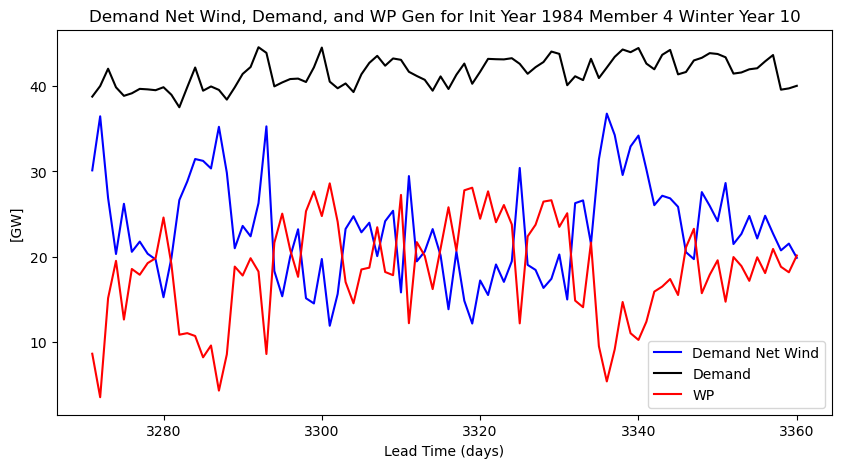

In [10]:
# -------------------------
# Plot a time series of the demand net wind, demand, and wp gen
# -------------------------

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the demand net wind
ax.plot(
    df_subset["lead"],
    df_subset["demand_net_wind_bc"],
    label="Demand Net Wind",
    color="blue",
)

# Plot the demand in black
ax.plot(
    df_subset["lead"],
    df_subset["data_tas_c_drift_bc_dt_UK_demand"],
    label="Demand",
    color="black",
)

# Plot the wind power generation in red
ax.plot(
    df_subset["lead"],
    df_subset["total_gen"],
    label="WP",
    color="red",
)

# Set the title and labels
ax.set_title(
    f"Demand Net Wind, Demand, and WP Gen for Init Year {test_init_year} Member {test_mem} Winter Year {test_winter_year}"
)
ax.set_xlabel("Lead Time (days)")
ax.set_ylabel("[GW]")

# Add a legend
ax.legend()

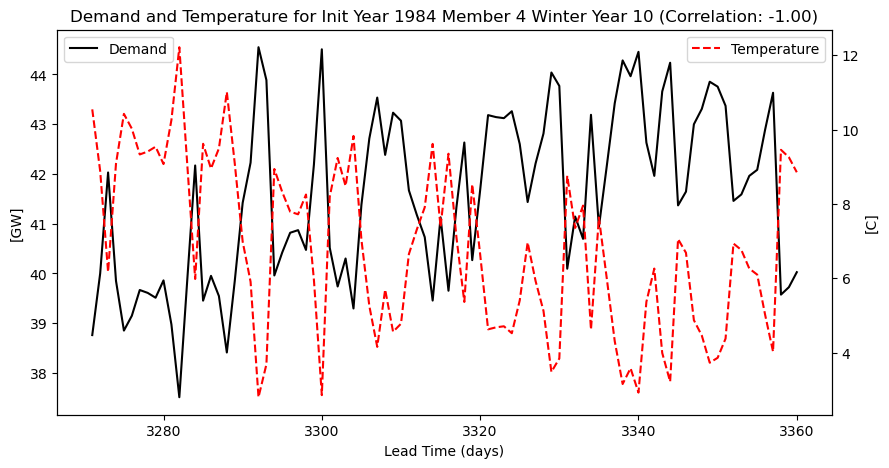

In [18]:
from scipy.stats import pearsonr

# Plot the demand in GW against inverted temperature data
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    df_subset["lead"],
    df_subset["data_tas_c_drift_bc_dt_UK_demand"],
    label="Demand",
    color="black",
)

# duplicate the axis
ax2 = ax.twinx()

ax2.plot(
    df_subset["lead"],
    df_subset["data_tas_c_drift_bc_dt"],
    label="Temperature",
    color="red",
    linestyle="--",
)

# invert the ax2
# ax2.invert_yaxis()

# calculate the correlation beteen demand and temperature
corr, _ = pearsonr(
    df_subset["data_tas_c_drift_bc_dt_UK_demand"],
    df_subset["data_tas_c_drift_bc_dt"],
)


# Set the title and labels
ax.set_title(
    f"Demand and Temperature for Init Year {test_init_year} Member {test_mem} Winter Year {test_winter_year} (Correlation: {corr:.2f})"
)
ax.set_xlabel("Lead Time (days)")
ax.set_ylabel("[GW]")
ax2.set_ylabel("[C]")

# Add a legend
ax.legend(loc="upper left")
ax2.legend(loc="upper right")


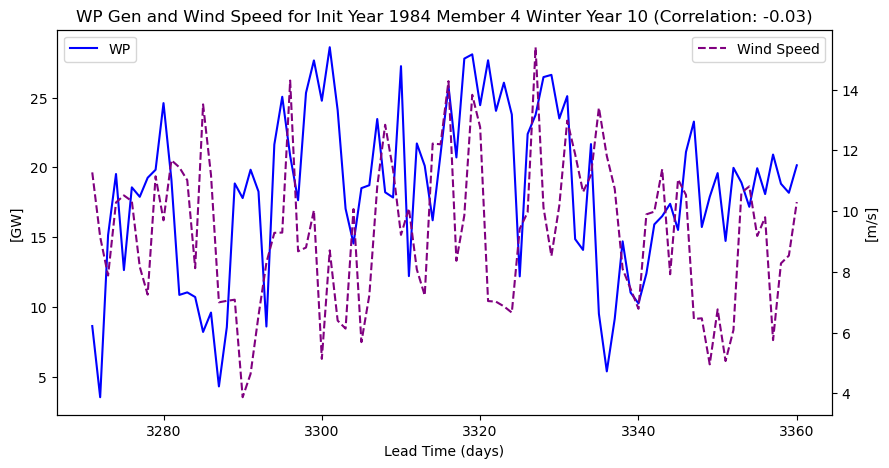

In [20]:
# ---------------------
# Now plo the WP generation against wind speed
# ---------------------

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    df_subset["lead"],
    df_subset["total_gen"],
    label="WP",
    color="blue",
)

ax2 = ax.twinx()

# Plot the wind speed
ax2.plot(
    df_subset["lead"],
    df_subset["data_sfcWind"],
    label="Wind Speed",
    color="purple",
    linestyle="--",
)

# calculate the correlation between WP generation and wind speed
corr_wp_wind, _ = pearsonr(
    df_subset["total_gen"],
    df_subset["data_sfcWind"],
)

# Set the title and labels
ax.set_title(
    f"WP Gen and Wind Speed for Init Year {test_init_year} Member {test_mem} Winter Year {test_winter_year} (Correlation: {corr_wp_wind:.2f})"
)
ax.set_xlabel("Lead Time (days)")
ax.set_ylabel("[GW]")
ax2.set_ylabel("[m/s]")

# Add a legend
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

